# Vanilla GAN of the MNIST dataset with KERAS

- For the overal architecture, I used [this blog post](https://www.datacamp.com/community/tutorials/generative-adversarial-networks)
- I then improved it using some [GAN hacks](https://github.com/soumith/ganhacks)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
print(tf.__version__) # Tensorflow 1.1.0
print(keras.__version__) # Keras 2.0 is required here (revert to it if needed) otherwise LeakyRelu doesn't work

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras.layers import Activation, Dense

from sklearn.utils import shuffle

from IPython import display

import pandas as pd



Using TensorFlow backend.


1.1.0
2.0.0


C:\Users\mednche\AppData\Local\conda\conda\envs\kerasproject\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

#import random
#seed = random.randint(0,9999)
#random.seed(seed)

### Load MNIST data

In [3]:
# load the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# normalize our inputs to be in the range[-1, 1]
X_train = (X_train.astype(np.float32) - 127.5)/127.5
# convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have 784 columns per row
X_train = X_train.reshape(60000, 784)

(X_train, y_train, X_test, y_test)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')


X_train shape: (60000, 784)
60000 training samples
10000 test samples


### Visualise MNIST data

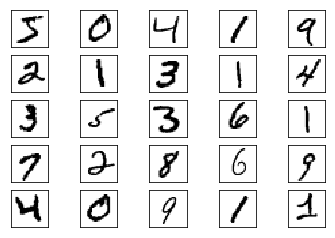

In [4]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(X_train.shape[0], 28, 28)[i], interpolation='nearest', cmap='gray_r')


In [5]:
# We will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [16]:
def get_generator(optimizer, random_dim):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer = 'uniform', bias_initializer = 'zeros'))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    generator.summary()
    return generator


In [17]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer = 'uniform', bias_initializer = 'zeros'))
    discriminator.add(LeakyReLU(alpha=0.3))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(alpha=0.3))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(alpha=0.3))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    discriminator.summary()
    return discriminator

In [18]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    
    # the output of the generator (an image)
    x = generator(gan_input)
    
    # get the output of the discriminator (probability of the image being real or not)
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output) # inputs and outputs under keras version 2.2.2
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    gan.summary()
    return gan

###  A function which will save your generated images every 20 epochs

In [9]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, random_dim, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

### Training the GAN

--------------- Epoch 1 ---------------
Cost of D after epoch 1: 0.415987
Cost of G after epoch 1: 1.746600
--------------- Epoch 2 ---------------
Cost of D after epoch 2: 0.468610
Cost of G after epoch 2: 2.419223
--------------- Epoch 3 ---------------
Cost of D after epoch 3: 0.481608
Cost of G after epoch 3: 1.996912
--------------- Epoch 4 ---------------
Cost of D after epoch 4: 0.505504
Cost of G after epoch 4: 1.350105
--------------- Epoch 5 ---------------
Cost of D after epoch 5: 0.408733
Cost of G after epoch 5: 2.097579
--------------- Epoch 6 ---------------
Cost of D after epoch 6: 0.445868
Cost of G after epoch 6: 2.141515
--------------- Epoch 7 ---------------
Cost of D after epoch 7: 0.420849
Cost of G after epoch 7: 2.220482
--------------- Epoch 8 ---------------
Cost of D after epoch 8: 0.508484
Cost of G after epoch 8: 2.267640
--------------- Epoch 9 ---------------
Cost of D after epoch 9: 0.455062
Cost of G after epoch 9: 1.944969
--------------- Epoch 10 ---

Cost of D after epoch 75: 0.684234
Cost of G after epoch 75: 0.892832
--------------- Epoch 76 ---------------
Cost of D after epoch 76: 0.657168
Cost of G after epoch 76: 0.862599
--------------- Epoch 77 ---------------
Cost of D after epoch 77: 0.679817
Cost of G after epoch 77: 0.845326
--------------- Epoch 78 ---------------
Cost of D after epoch 78: 0.657376
Cost of G after epoch 78: 0.839673
--------------- Epoch 79 ---------------
Cost of D after epoch 79: 0.680327
Cost of G after epoch 79: 0.867621
--------------- Epoch 80 ---------------
Cost of D after epoch 80: 0.665028
Cost of G after epoch 80: 0.874836
--------------- Epoch 81 ---------------
Cost of D after epoch 81: 0.638494
Cost of G after epoch 81: 0.897463
--------------- Epoch 82 ---------------
Cost of D after epoch 82: 0.645929
Cost of G after epoch 82: 0.838330
--------------- Epoch 83 ---------------
Cost of D after epoch 83: 0.680813
Cost of G after epoch 83: 0.871500
--------------- Epoch 84 ---------------
C

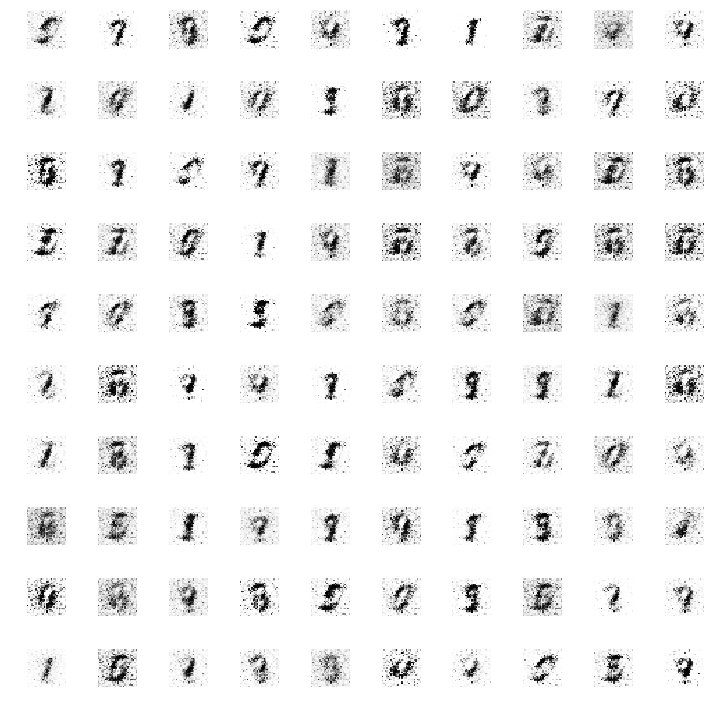

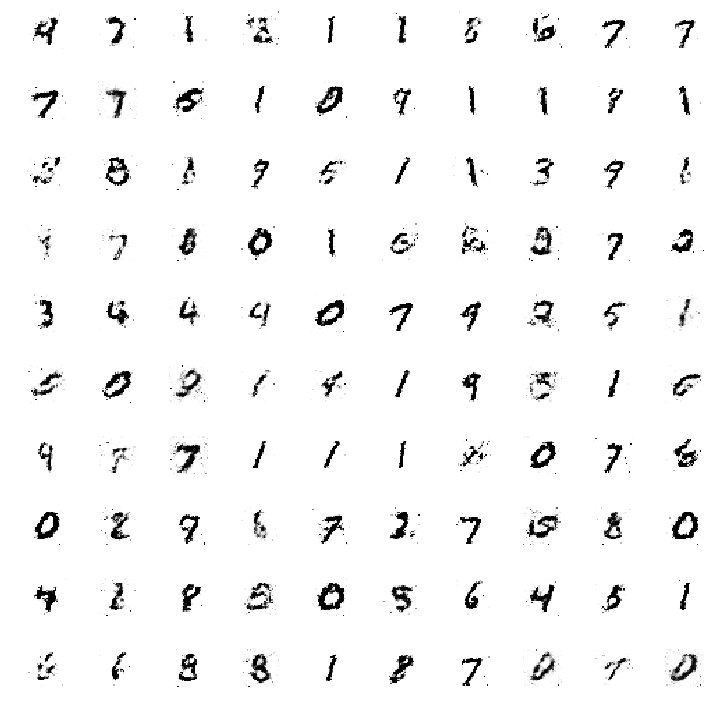

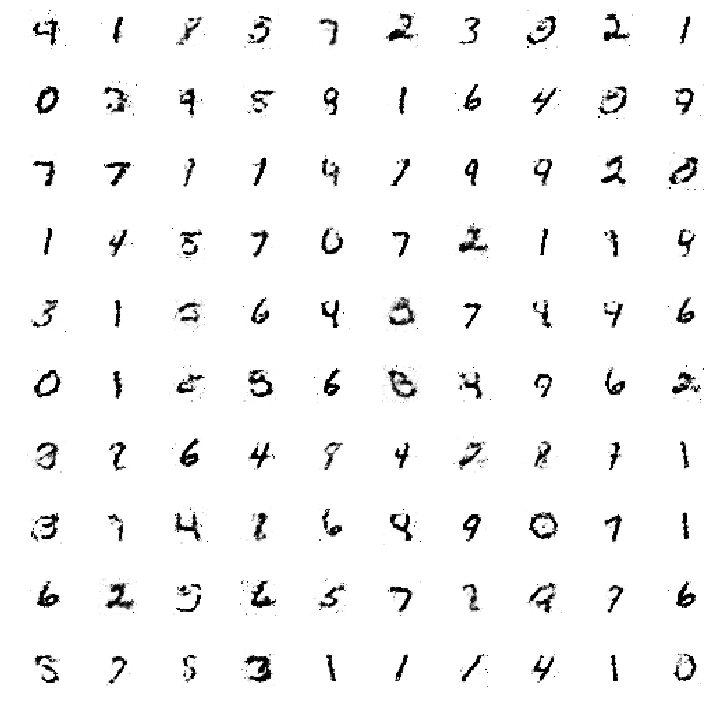

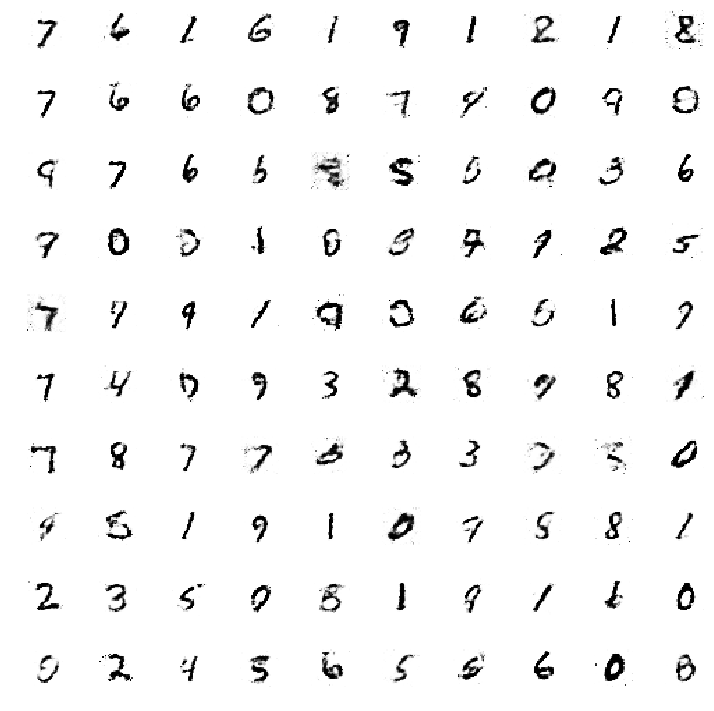

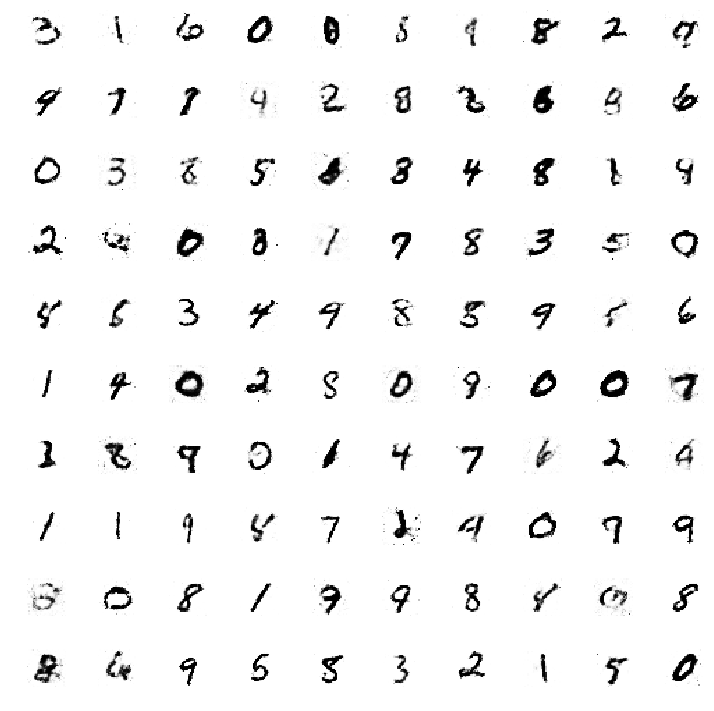

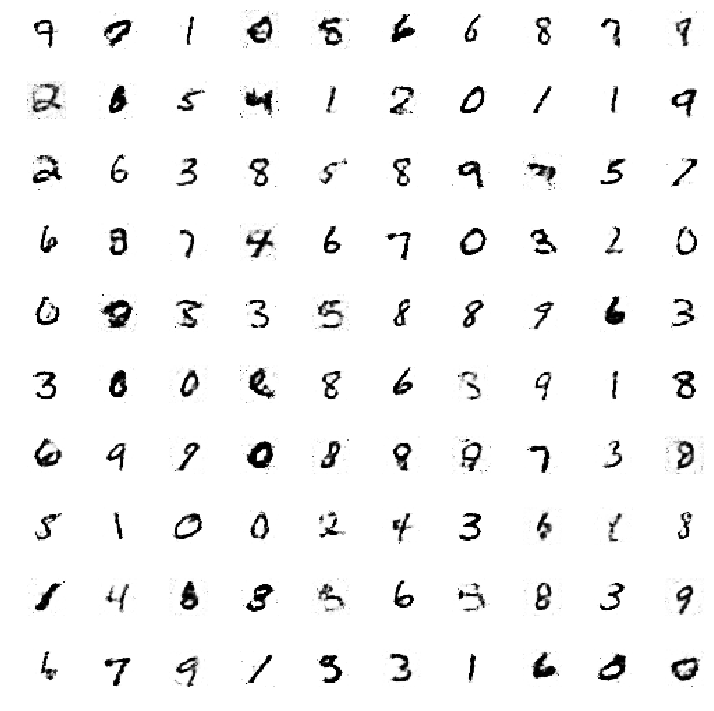

In [10]:
def train(X_train, y_train, x_test, y_test, epochs=100, minibatch_size=128, random_dim = 100):

# Build our GAN network
    adam = get_optimizer()
    G = get_generator(adam, random_dim)
    D = get_discriminator(adam)
    gan = get_gan_network(D, random_dim, G, adam)
    
    # for plotting at the end
    D_loss = []
    G_loss = []

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        
        # Defines a cost related to an epoch
        epoch_cost = 0.                       
        
        
        # get number of minibatch based on size of data
        num_minibatches = int(X_train.shape[0] / minibatch_size) # number of minibatches of size minibatch_size in the train set
        
        # Randomize data point
        X_train, y_train = shuffle(X_train, y_train)
        
        
        # Split the training data into batches of size 128
        for i in range(0, X_train.shape[0], minibatch_size):
            #print(i)
            
            # Get pair of (X, y) of the current minibatch
            X_train_mini = X_train[i:i + minibatch_size]
            y_train_mini = y_train[i:i + minibatch_size]
                
                
            ##### Train discriminator #####
            # Get a set of legit images from MNIST data
            legit_images = X_train_mini[np.random.randint(0, X_train_mini.shape[0], size=int(minibatch_size/2))]

            # Get a set of fake images generated from noise
            noise = np.random.normal(0, 1, size=[int(minibatch_size/2), random_dim]) # random_dim = 100 here
            syntetic_images = G.predict(noise)
    
    
            # create 1 dataset with both legit (1) and generated (0) images
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((int(minibatch_size/2), 1)), np.zeros((int(minibatch_size/2), 1))))
            y_combined_batch[:int(minibatch_size/2)] = 0.9 # only for real images

            # Train discriminator
            D.trainable = True
            d_loss = D.train_on_batch(x_combined_batch, y_combined_batch)
            D_loss.append(d_loss)
            
            
            ###### Train generator #####
            noise = np.random.normal(0, 1, size=[minibatch_size, random_dim])
            y_gen = np.ones(minibatch_size)
            D.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)
            G_loss.append(g_loss)

            
        print ("Cost of D after epoch %i: %f" % (e, d_loss))
        print ("Cost of G after epoch %i: %f" % (e, g_loss))
            
               
            
        if e == 1 or e % 20 == 0:
            
            
            """# PLOT examples of 5 first synthetic images created by G
            for i in range(5):
                plt.subplot(5,5,i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(syntetic_images.reshape(int(minibatch_size/2), 28, 28)[i], interpolation='nearest', cmap='gray_r')
            plt.show()"""
            
            plot_generated_images(e, G, random_dim)
            
    # Save models in case (creates a HDF5 file 'model.h5')    
    G.save_weights('Generator.h5') 
    D.save_weights('Discriminator.h5')
    
    return [D_loss, G_loss]
       
                  
            
            
if __name__ == '__main__':
    [D_loss, G_loss] = train(X_train, y_train, X_test, y_test, epochs = 100, minibatch_size=128, random_dim = 100) # random_dim = The dimension of our random noise vector.
    
    

### Visualise loss of D and G

Text(0,0.5,'Loss')

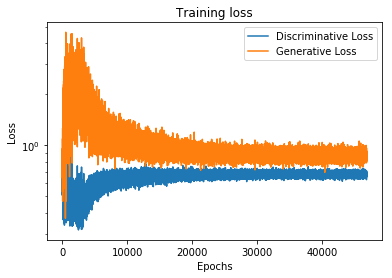

In [11]:
ax = pd.DataFrame({'Generative Loss': G_loss, 'Discriminative Loss': D_loss,}).plot(title='Training loss', logy=True, )
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [31]:
## Get the trained weights post training


#from keras.models import load_weights

# Returns a compiled model identical to the previous one
adam = get_optimizer()
random_dim = 100
G1 = get_generator(adam, random_dim)
D1 = get_discriminator(adam)


G1.load_weights('Generator.h5')
D1.load_weights('Discriminator.h5')